<a href="https://colab.research.google.com/github/Taiba528/Datasciencecoursera/blob/master/Turbofan_failure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from random import randint, shuffle
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
uploaded=files.upload()

Saving train_data.csv to train_data.csv


In [0]:
df_train = pd.read_csv("train_data.csv")

In [5]:
df_train.head()

,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,RUL
0,0,1,25.0074,0.6200,60.0,462.54,536.84,1256.52,1043.97,7.05,9.02,175.29,1915.47,8019.94,0.94,36.70,164.75,2028.38,7875.47,10.8850,0.02,306,1915,84.93,14.35,8.4712,NaN,NaN,NaN,NaN,NaN,NaN,339
1,0,2,35.0072,0.8413,100.0,449.44,555.44,1364.42,1128.75,5.48,8.00,194.71,2223.06,8361.86,1.03,41.78,183.67,2388.20,8073.12,9.2527,0.02,334,2223,100.00,14.88,8.9928,NaN,NaN,NaN,NaN,NaN,NaN,338
2,0,3,25.0053,0.6215,60.0,462.54,536.42,1265.94,1047.23,7.05,9.03,175.29,1915.49,8021.37,0.94,36.49,164.49,2028.40,7884.88,10.9054,0.02,307,1915,84.93,14.21,8.5107,NaN,NaN,NaN,NaN,NaN,NaN,337
3,0,4,42.0045,0.8407,100.0,445.00,549.41,1355.52,1115.81,3.91,5.72,138.92,2212.03,8319.14,1.02,41.78,130.67,2388.13,8093.08,9.3434,0.02,331,2212,100.00,10.63,6.4578,NaN,NaN,NaN,NaN,NaN,NaN,336
4,0,5,35.0046,0.8400,100.0,449.44,555.21,1361.04,1123.63,5.48,8.00,194.91,2223.10,8357.89,1.03,41.79,183.02,2388.19,8078.18,9.3287,0.02,334,2223,100.00,14.95,9.0279,NaN,NaN,NaN,NaN,NaN,NaN,335


In [6]:
from google.colab import files
uploaded=files.upload()

Saving test_data.csv to test_data.csv


In [7]:
df_test = pd.read_csv("test_data.csv")
df_test.head()

,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27
0,0,1,42.0034,0.8400,100.0,445.00,549.36,1342.05,1124.56,3.91,5.71,138.59,2211.83,8311.68,1.02,41.93,130.98,2387.90,8077.78,9.3092,0.02,329,2212,100.0,10.69,6.3956,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,42.0017,0.8400,100.0,445.00,548.83,1351.93,1116.28,3.91,5.71,138.20,2211.79,8312.85,1.02,41.92,130.30,2387.89,8077.82,9.3450,0.02,331,2212,100.0,10.55,6.3775,NaN,NaN,NaN,NaN,NaN,NaN
2,0,3,0.0028,0.0019,100.0,518.67,642.35,1583.74,1400.44,14.62,21.61,554.46,2388.07,9052.16,1.30,47.43,521.83,2388.04,8129.19,8.3840,0.03,392,2388,100.0,38.85,23.3483,NaN,NaN,NaN,NaN,NaN,NaN
3,0,4,42.0047,0.8400,100.0,445.00,549.69,1354.36,1125.55,3.91,5.72,139.05,2211.81,8310.83,1.02,41.83,131.15,2387.82,8082.04,9.3852,0.02,330,2212,100.0,10.56,6.4871,NaN,NaN,NaN,NaN,NaN,NaN
4,0,5,10.0058,0.2506,100.0,489.05,604.72,1496.65,1310.52,10.52,15.49,394.71,2318.91,8760.80,1.26,45.25,371.57,2388.10,8121.73,8.6074,0.03,370,2319,100.0,28.78,17.1987,NaN,NaN,NaN,NaN,NaN,NaN


# Split train - eval


In [13]:
list_engine_no = list(df_train['engine_no'].drop_duplicates())
len(list_engine_no)

709

In [11]:
ratio = .3
shuffle(list_engine_no)
engine_no_test = list_engine_no[:int(len(list_engine_no) * ratio)]
len(engine_no_test)


212

In [12]:
engine_no_train = [x for x in list_engine_no if x not in engine_no_test]
len(engine_no_train)


497

In [14]:
nan_column = df_train.columns[df_train.isna().any()].tolist()
const_columns = [c for c in df_train.columns if len(df_train[c].drop_duplicates()) <= 2]
print('Columns with all nan: \n' + str(nan_column) + '\n')
print('Columns with all const values: \n' + str(const_columns) + '\n')


Columns with all nan: 
['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27']

Columns with all const values: 
['op_setting_3', 'sensor_16', 'sensor_19', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27']



In [18]:
metadata_columns = ['engine_no', 'time_in_cycles']
selected_features = [x for x in df_test.columns if x not in metadata_columns + nan_column + const_columns]
selected_features

['op_setting_1',
 'op_setting_2',
 'sensor_1',
 'sensor_2',
 'sensor_3',
 'sensor_4',
 'sensor_5',
 'sensor_6',
 'sensor_7',
 'sensor_8',
 'sensor_9',
 'sensor_10',
 'sensor_11',
 'sensor_12',
 'sensor_13',
 'sensor_14',
 'sensor_15',
 'sensor_17',
 'sensor_18',
 'sensor_20',
 'sensor_21']

In [0]:
df_train_train = df_train[df_train['engine_no'].isin(engine_no_train)]
data_eval = df_train[df_train['engine_no'].isin(engine_no_test)]

X_train_train, y_train_train = df_train_train[selected_features], df_train_train['RUL'] 
X_eval, y_eval = data_eval[selected_features], data_eval['RUL']

X_train_all, y_train_all = df_train[selected_features], df_train['RUL']

X_test = df_test[selected_features]

# Train the classifier

In [20]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=20)
tree.fit(X_train_train, y_train_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Check overfitting/underfitting

In [21]:
print("Score on train data : " + str(tree.score(X_train_train, y_train_train)))
print("Score on eval data : " + str(tree.score(X_eval, y_eval)))

Score on train data : 0.20885385727078476
Score on eval data : 0.015366181787606155


# Train on all the dataset

In [22]:
tree.fit(X_train_all, y_train_all)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Make prediction

In [0]:
df_train['pred_tree'] = tree.predict(X_train_all)
df_test['pred_tree'] = tree.predict(X_test)

# Make Decision

In [0]:
df_train = df_train.sort_values(['engine_no', 'time_in_cycles'])
df_test = df_test.sort_values(['engine_no', 'time_in_cycles'])


In [27]:
df_result = df_test.groupby('engine_no').last().reset_index()[['engine_no', 'pred_tree']]
df_result

,engine_no,pred_tree
0,0,41
1,1,24
2,2,180
3,3,183
4,4,5
...,...,...
702,702,129
703,703,163
704,704,46
705,705,61


In [28]:
df_result['result'] = df_result['pred_tree'].map(lambda x: 0 if x > 100 else 1)
df_result['result'] 

0      1
1      1
2      0
3      0
4      1
      ..
702    0
703    0
704    1
705    1
706    1
Name: result, Length: 707, dtype: int64

# Plotting the result

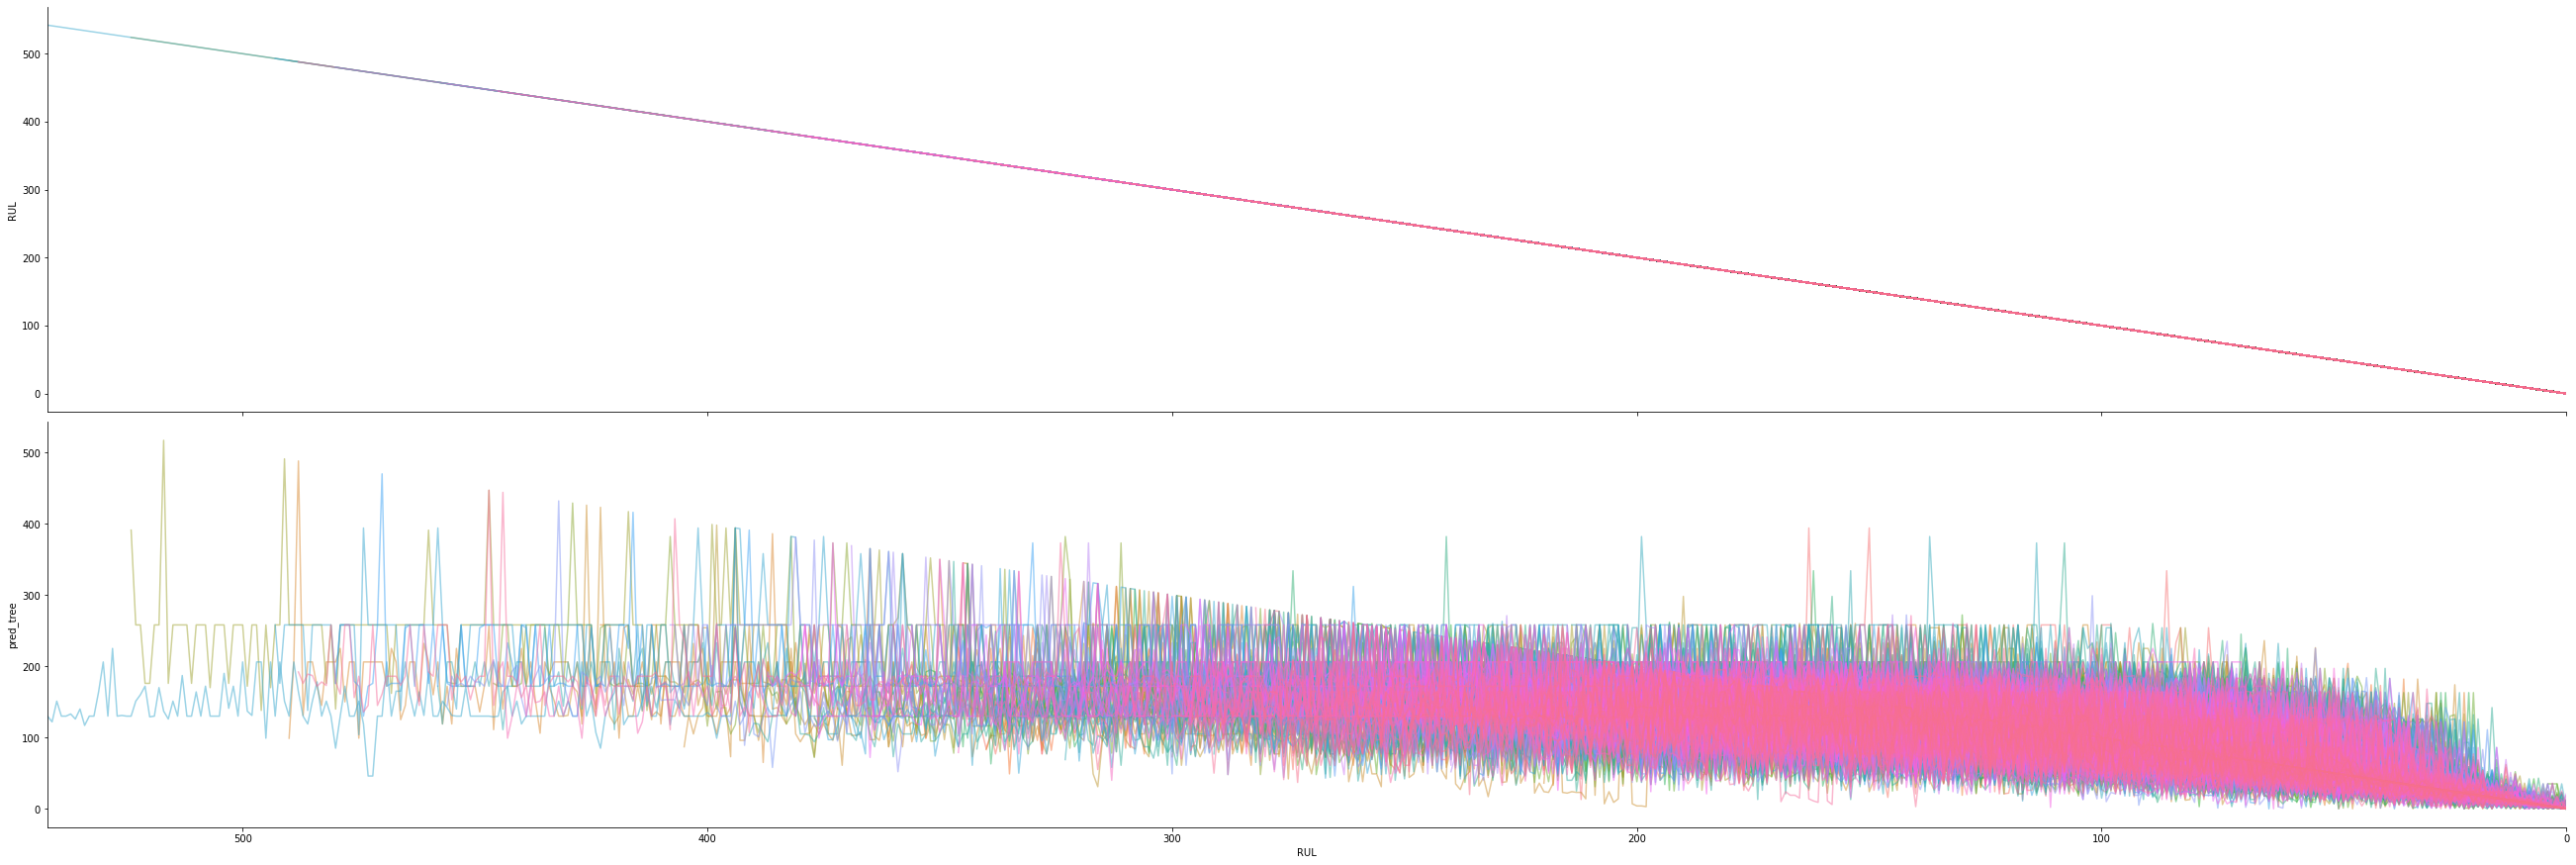

In [29]:
df_plot = df_train.copy()
df_plot = df_plot.sort_values(['engine_no', 'time_in_cycles'])
g = sns.PairGrid(data=df_plot, x_vars="RUL", y_vars=['RUL', 'pred_tree'], hue="engine_no", height=6, aspect=6,)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(df_plot['RUL'].max(),df_plot['RUL'].min()))